# Проект для «Викишоп» с BERT

__ОПИСАНИЕ:__ Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. 

__ЦЕЛЬ:__
Создать инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

__ЗАДАЧИ:__ 
1. Обучить модель классифицировать комментарии на позитивные и негативные
2. Достичь метрику качества *F1* не менее 0.75. 

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>TF-IDF</a></span><ul class="toc-item"><li><span><a href="#Подготовка-фич" data-toc-modified-id="Подготовка-фич-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подготовка фич</a></span></li><li><span><a href="#Логичтическая-регрессия" data-toc-modified-id="Логичтическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Логичтическая регрессия</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Catboost</a></span></li></ul></li><li><span><a href="#BERT" data-toc-modified-id="BERT-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>BERT</a></span><ul class="toc-item"><li><span><a href="#Загрузка-предобученной-модели-DistilBERT-и-токенизатора" data-toc-modified-id="Загрузка-предобученной-модели-DistilBERT-и-токенизатора-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Загрузка предобученной модели DistilBERT и токенизатора</a></span></li><li><span><a href="#Padding" data-toc-modified-id="Padding-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Padding</a></span></li><li><span><a href="#Masking" data-toc-modified-id="Masking-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Masking</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Подготовка

Импорт библиотек

In [ ]:
# !pip install transformers
# conda install pytorch torchvision -c pytorch

In [1]:
import torch
import transformers as ppb

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk


from tqdm import notebook 
from catboost import CatBoostClassifier, Pool

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/vladimirgavrilev/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
df_wiki = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [4]:
df_wiki.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [5]:
df_wiki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
df_wiki.toxic.value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

In [7]:
df_wiki.duplicated().sum()

0

__Заметка__
- всего порядка 160 тысяч объектов
- десятая доля описания товаров промаркирована как токсичная
- явных дубликатов нет

## TF-IDF

In [8]:
# приведем текст в нижний регистр
df_wiki['text'] = df_wiki['text'].apply(lambda x: x.lower())

In [9]:
df_wiki.head()

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0



### Подготовка фич

In [12]:
# Функция для отметки POS-тега
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:		
        return None

# функция вернет лемму каждого слова
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    
    # токенизируем предложение и найдем тег POS для каждого токена
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), nltk.pos_tag(nltk.word_tokenize(text))))
    
    lemmatized_text = []
    
    for word, tag in wordnet_tagged:
        if tag is None:
            # если нет доступного тега, оставим токен как есть
            lemmatized_text.append(word)
        else:
            lemmatized_text.append(lemmatizer.lemmatize(word, tag))
            
    return (" ".join(lemmatized_text))

# функция оставит в тексте только латинские символы и пробелы
def clear_text(text):
    text_ = re.sub(r"[^a-z]", ' ', text) # находит в тексте все совпадения по шаблону и заменяет их заданной строкой.
    return ' '.join(text_.split()) # пробелы устраняются комбинацией функций join() и split().

In [13]:
%time

df_wiki['lemm_text'] = df_wiki['text'].apply(lambda x: lemmatize(clear_text(x)))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


In [14]:
df_wiki.head()

,text,toxic,lemm_text
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he match this background colour i m seem...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not try to edit war it s ju...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"you, sir, are my hero. any chance you remember...",0,you sir be my hero any chance you remember wha...


Создадим фичи и таргеты

In [15]:
features = df_wiki['lemm_text']
target = df_wiki['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.2,random_state = 12345)

Загрузим список стоп-слов

In [16]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

# создадим счётчик, указав в нём стоп-слова:
count_tf_idf = TfidfVectorizer(stop_words = stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vladimirgavrilev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Расчет TF-IDF для корпуса текстов

In [17]:
tf_idf_train = count_tf_idf.fit_transform(features_train) 
tf_idf_test = count_tf_idf.transform(features_test)

### Логичтическая регрессия

In [18]:
target_train.value_counts()

0    114670
1     12986
Name: toxic, dtype: int64

Запустим логистическую регрессию с применением кросс-валидации

In [19]:
%%time

lr_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lr_model = LogisticRegression(random_state = 123, 
                              solver = 'liblinear', 
                              class_weight={1: 9})

grid_search = GridSearchCV(lr_model, # задаем модель
                           lr_parameters, # гиперпараметры
                           cv = 5, # количество разбиений на кросс-валидацию ( < 3 делать не стоит)
                           scoring = 'f1' # по какой метрике будем оценивать модель 
                           )  
#обучение модели 
grid_search.fit(tf_idf_train, target_train)

CPU times: user 7min 14s, sys: 1min 36s, total: 8min 51s
Wall time: 1min 12s


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight={1: 9}, random_state=123,
                                          solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             scoring='f1')

In [20]:
grid_search.best_score_

0.7536651510337359

In [21]:
grid_search.best_estimator_
f1_score(target_test, grid_search.predict(tf_idf_test))

0.7546091181935115

### Catboost

In [23]:
%%time

CBC = CatBoostClassifier()


parameters = {'depth': [10],
              'learning_rate' : [1],
              'iterations' : [100],
              'auto_class_weights': ['Balanced']
             }

Grid_CBC = GridSearchCV(estimator=CBC, 
                        param_grid = parameters, 
                        scoring = 'f1',
                        cv = 3, 
                        n_jobs=-1
                        )

Grid_CBC.fit(tf_idf_train, target_train)
Grid_CBC.best_score_

0:	learn: 0.5153424	total: 5.14s	remaining: 8m 28s
1:	learn: 0.4695340	total: 10.8s	remaining: 8m 47s
2:	learn: 0.4350017	total: 16.3s	remaining: 8m 47s
3:	learn: 0.4075823	total: 21.8s	remaining: 8m 44s
4:	learn: 0.3888728	total: 27.5s	remaining: 8m 42s
5:	learn: 0.3748971	total: 33s	remaining: 8m 37s
6:	learn: 0.3628253	total: 38.6s	remaining: 8m 32s
7:	learn: 0.3530023	total: 44.2s	remaining: 8m 28s
8:	learn: 0.3470480	total: 49.7s	remaining: 8m 22s
9:	learn: 0.3407501	total: 55.3s	remaining: 8m 17s
10:	learn: 0.3333196	total: 1m	remaining: 8m 12s
11:	learn: 0.3245971	total: 1m 6s	remaining: 8m 7s
12:	learn: 0.3174977	total: 1m 12s	remaining: 8m 2s
13:	learn: 0.3085433	total: 1m 17s	remaining: 7m 57s
14:	learn: 0.2998714	total: 1m 23s	remaining: 7m 51s
15:	learn: 0.2945839	total: 1m 28s	remaining: 7m 46s
16:	learn: 0.2886171	total: 1m 34s	remaining: 7m 41s
17:	learn: 0.2833213	total: 1m 40s	remaining: 7m 35s
18:	learn: 0.2782958	total: 1m 45s	remaining: 7m 30s
19:	learn: 0.2747481	t

0.7115858579175692

In [24]:
Grid_CBC.best_estimator_
f1_score(target_test, Grid_CBC.predict(tf_idf_test))

0.707798225870515

На тестовой выборке получили результаты выше пороговой:
- На логистической регрессии __0.754__
- На Catboost __0.71__

## BERT

В связи с нехваткой ресурсов для работы с BERT, оставим только 2000 объектов и будем использовать DistilBERT. Более облегченную версию BERT

In [27]:
df_wiki = df_wiki.drop(columns = {'lemm_text'}, axis = 1)
df_wiki = df_wiki.sample(2000).reset_index(drop = True)
df_wiki.head()

,text,toxic
0,"""\n\n i think the original explanation was ter...",0
1,you did not answer my question again. \n\nques...,1
2,"""please do not add nonsense to wikipedia. it i...",0
3,surely though there must be something to indic...,0
4,university college of gävle\nhi - thanks for t...,0


### Загрузка предобученной модели DistilBERT и токенизатора

In [28]:
model_class, tokenizer_class, pretrained_weights = (
    ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Загрузка предобученной модели/токенизатора 
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Теперь мы можем токенизировать набор данных. Токенизируем и обрабатываем все предложения вместе в одном пакете

In [29]:
tokenized = df_wiki.text.apply(lambda x: tokenizer.encode(x, add_special_tokens = True))

Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors


In [30]:
tokenized.head()

0    [101, 1000, 1045, 2228, 1996, 2434, 7526, 2001...
1    [101, 2017, 2106, 2025, 3437, 2026, 3160, 2153...
2    [101, 1000, 3531, 2079, 2025, 5587, 14652, 200...
3    [101, 7543, 2295, 2045, 2442, 2022, 2242, 2000...
4    [101, 2118, 2267, 1997, 11721, 2615, 2571, 763...
Name: text, dtype: object

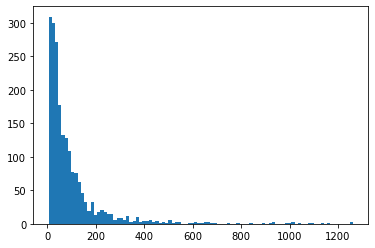

In [31]:
plt.hist(
    tokenized.apply(lambda x: len(x)), 
    bins = 'auto')

plt.show()

Удалим объекты с количеством токенов более 512. BERT не схваает.

In [32]:
drop_index = []
for i in range(len(tokenized)):
    if (len(tokenized[i]) > 512):
        drop_index.append(i)

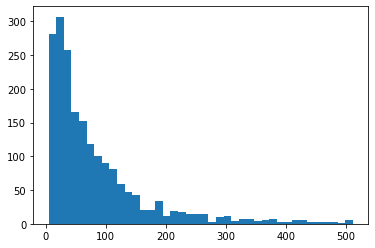

In [33]:
tokenized.drop(index = drop_index, inplace = True)
df_wiki.drop(index = drop_index, inplace = True)

plt.hist(
    tokenized.apply(lambda x: len(x)), 
    bins = 'auto')

plt.show()

In [34]:
df_wiki.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1961 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1961 non-null   object
 1   toxic   1961 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 46.0+ KB


In [35]:
tokenized_short = tokenized.sample(1900)

In [40]:
tokenized_short.head()

325     [101, 4931, 999, 2053, 2062, 9180, 2100, 1011,...
1473    [101, 1000, 7632, 2045, 4283, 2005, 2115, 2785...
473     [101, 2625, 2066, 3085, 7696, 2182, 1012, 2928...
1482    [101, 1000, 1063, 1064, 2806, 1027, 1000, 1000...
1098    [101, 1000, 2026, 21792, 2050, 4283, 4283, 200...
Name: text, dtype: object

In [41]:
df_wiki_short = df_wiki.loc[tokenized_short.index]

In [42]:
df_wiki_short.head()

,text,toxic
325,hey! \n\nno more hanky-panky on a shrunken san...,0
1473,"""\n\nhi there\n\nthanks for your kind comment!...",0
473,less likeable messages here. mark i know you a...,0
1482,"""\n{| style=""""background-color:#f5fffa; paddin...",0
1098,"""\n\n my rfa \n\nthanks thanks for your recen...",0


После токенизации __tokenized__ представляет собой список (или объект Series/DataFrame из pandas). Мы хотим, чтобы BERT обрабатывал все наши примеры одновременно (как один пакет). Так будет быстрее. По этой причине нам нужно привести все списки до одинакового размера, чтобы мы могли представить вектора как один двумерный массив, а не список списков разной длины.

Таким образом, мы получаем матрицу/тензор, который можно передавать BERT'у:

### Padding

In [43]:
max_len = 0
for i in tokenized_short.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized_short.values])

Наш набор данных теперь находится в переменной padded с размером

In [44]:
padded.shape

(1900, 512)

### Masking

Если мы напрямую отправим padded в BERT, это немного запутает его. 

Теперь поясним модели, что нули не несут значимой информации. Это нужно для компоненты модели, которая называется «внимание» (англ. attention). Отбросим эти токены и «создадим маску» для действительно важных токенов, то есть укажем нулевые и не нулевые значения:

In [45]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(1900, 512)

### Обучение модели

Теперь создадим входной вектор из матрицы токенов и передадим его в DistilBERT.

In [46]:
batch_size = 100

# сделаем пустой список для хранения эмбеддингов
embeddings = []

# Сделаем цикл по батчам. Отображать прогресс будет функция notebook()
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    # преобразуем данные
    batch = torch.LongTensor(padded[batch_size * i: batch_size * (i+1)]) 
    # преобразуем маску
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i:batch_size*(i+1)])
    
    # Для ускорения вычисления функцией no_grad() (англ. no gradient, «нет градиента») 
    # в библиотеке torch укажем, что градиенты не нужны: модель BERT обучать не будем.  
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask = attention_mask_batch)
        
    # Из полученного тензора извлечём нужные элементы и добавим в список всех эмбеддингов
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/19 [00:00<?, ?it/s]

In [47]:
# Соберём все эмбеддинги в матрицу признаков вызовом функции concatenate()
features = pd.DataFrame(np.concatenate(embeddings))

target = df_wiki_short['toxic']
target = target.reset_index(drop = True)

In [48]:
# подготовим фичи и таргеты
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.2,random_state = 12345)

### Логистическая регрессия

Запустим с кросс-валидацией

In [49]:
%%time

lr_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lr_model = LogisticRegression(random_state = 123, 
                              solver = 'liblinear', 
                              class_weight={1: 9})

grid_search = GridSearchCV(lr_model, # задаем модель
                           lr_parameters, # гиперпараметры
                           cv = 5, # количество разбиений на кросс-валидацию ( < 3 делать не стоит)
                           scoring = 'f1' # по какой метрике будем оценивать модель 
                           )  
#обучение модели 
grid_search.fit(features_train, target_train)
grid_search.best_estimator_
f1_score(target_test, grid_search.predict(features_test))

CPU times: user 41.6 s, sys: 6.51 s, total: 48.1 s
Wall time: 8.57 s


0.6067415730337079

### CatBoost

In [53]:
%%time

#from sklearn.utils.class_weight import compute_class_weight 
#classes = np.unique(target_train)
#weights = compute_class_weight(class_weight='balanced', classes=classes, y=target_train)
#class_weights = dict(zip(classes, weights))

#CBC = CatBoostClassifier(class_weights=class_weights)

CBC = CatBoostClassifier()


parameters = {'depth': [5],
              'learning_rate' : [1],
              'iterations'    : [100],
              'auto_class_weights': ['Balanced']
             }

Grid_CBC = GridSearchCV(estimator=CBC, 
                        param_grid = parameters, 
                        scoring = 'f1',
                        cv = 3, 
                        verbose = 50,
                        n_jobs=-1
                        )

Grid_CBC.fit(features_train, target_train)
Grid_CBC.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 0.4013888	total: 49.5ms	remaining: 4.9s
1:	learn: 0.3319241	total: 81.5ms	remaining: 3.99s
2:	learn: 0.2608376	total: 114ms	remaining: 3.69s
3:	learn: 0.2063914	total: 149ms	remaining: 3.56s
4:	learn: 0.1651358	total: 182ms	remaining: 3.46s
5:	learn: 0.1440987	total: 216ms	remaining: 3.38s
6:	learn: 0.1186688	total: 253ms	remaining: 3.35s
7:	learn: 0.0960855	total: 292ms	remaining: 3.36s
8:	learn: 0.0773968	total: 332ms	remaining: 3.36s
9:	learn: 0.0730385	total: 363ms	remaining: 3.26s
10:	learn: 0.0613917	total: 394ms	remaining: 3.19s
11:	learn: 0.0528494	total: 432ms	remaining: 3.16s
12:	learn: 0.0428810	total: 474ms	remaining: 3.17s
13:	learn: 0.0414051	total: 518ms	remaining: 3.18s
14:	learn: 0.0354475	total: 561ms	remaining: 3.18s
15:	learn: 0.0294516	total: 604ms	remaining: 3.17s
16:	learn: 0.0266822	total: 648ms	remaining: 3.16s
17:	learn: 0.0255150	total: 693ms	remaining: 3.15s
18:	learn: 0.0232240	total: 732m

In [54]:
Grid_CBC.best_score_
f1_score(target_test, Grid_CBC.predict(features_test))

0.625

## Выводы

Итак мы обучили несколько моделей для целей определения токсичных описаний для Викишопа.

Модель логистической регресии на основе векторизации TF-IDF дала результат по метрике f1 выше порога - 0.754

Модели на ембеддингах, к сожалению дали результаты ниже порога. Это связано с небольшим количеством объектов участвующих в обучении из-за высокой потребности в ресурсах к модели BERT.

Бустинги очень легко переобучаются. В нашем случае мы классифицируем по сути своей не особо осмысленные вектора, которые ещё и обладают большой размерностью - это, скорее всего, приводит к переобучению и худшим метрикам на тестовой выборке.